In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import imageio.v3 as imageio

# Get $I_1$ images

In [2]:
path_to_I1 = os.getcwd() + '\\I1\\'

In [3]:
list_dir_I1 = [int(file.split(".")[0]) for file in os.listdir(path_to_I1)]
list_dir_I1.sort()
list_I1_images = []
for file_name in list_dir_I1:
    img = cv2.imread(filename=path_to_I1 + str(file_name) + ".png")
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    list_I1_images.append(img)
list_I1_images = np.array(list_I1_images)

# Get $I_2$ images

In [4]:
path_to_I2 = os.getcwd() + '\\I2\\'

In [5]:
list_dir_I2 = [int(file.split(".")[0]) for file in os.listdir(path_to_I2)]
list_dir_I2.sort()
list_I2_images = []
for file_name in list_dir_I2:
    img = cv2.imread(filename=path_to_I2 + str(file_name) + ".png")
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    list_I2_images.append(img)
list_I2_images = np.array(list_I2_images)

In [6]:
list_I2_images.shape

(60, 176, 336)

# Get saliency mask

In [7]:
path_to_saliency = os.getcwd() + '\\saliency.png'

In [8]:
saliency = cv2.imread(filename=path_to_saliency)
saliency = cv2.cvtColor(src=saliency, code=cv2.COLOR_BGR2GRAY)
saliency[saliency > 0] = 255

# Get seperate saliency masks

In [321]:
path_to_saliency1 = os.getcwd() + '\\2900_saliency.png'
path_to_saliency2 = os.getcwd() + '\\2909_saliency.png'

In [ ]:
saliency1 = cv2.imread(filename=path_to_saliency1)
saliency1 = cv2.cvtColor(src=saliency1, code=cv2.COLOR_BGR2GRAY)
saliency1[saliency1 > 0] = 255

saliency2 = cv2.imread(filename=path_to_saliency2)
saliency2 = cv2.cvtColor(src=saliency2, code=cv2.COLOR_BGR2GRAY)
saliency2[saliency2 > 0] = 255

# Homography estimation

In [9]:
img1 = list_I1_images[50]
img2 = list_I2_images[50]

In [10]:
# Detect features
detector = cv2.SIFT_create()
matcher = cv2.BFMatcher(normType=cv2.NORM_L2, crossCheck=True)
kp1, des1 = detector.detectAndCompute(img1, None)
kp2, des2 = detector.detectAndCompute(img2, None)
matches = matcher.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

In [11]:
# Filter by saliency
thres = 100
p1 = [[int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])] for m in matches]
p2 = [[int(kp2[m.trainIdx].pt[0]), int(kp2[m.trainIdx].pt[1])] for m in matches]
matches = [matches[i] for i in range(len(matches)) if saliency[p1[i][1], p1[i][0]] > thres and saliency[p2[i][1], p2[i][0]] > thres]

# Filter by 2 different saliency masks

In [325]:
# Filter by saliency
thres = 100
p1 = [[int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1])] for m in matches]
p2 = [[int(kp2[m.trainIdx].pt[0]), int(kp2[m.trainIdx].pt[1])] for m in matches]
matches = [matches[i] for i in range(len(matches)) if saliency1[p1[i][1], p1[i][0]] > thres and saliency2[p2[i][1], p2[i][0]] > thres]

In [12]:
len(matches)

26

In [13]:
# Drawing matched result
match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
imageio.imwrite(os.getcwd() + '\\_tmp.jpg', match_img)

In [14]:
# Model image plane movement
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

In [15]:
# Warp according to homography
height, width = img1.shape[:2]
img1_warp = cv2.warpPerspective(img1, M, (width, height))

# Only move non saliency part
fix_saliency_thres = 200
mask = saliency > fix_saliency_thres
img1_warp[mask] = img2[mask]

In [905]:
# Finding maximum bbox
bbox = np.array([[0, 0, 1], [img1.shape[1], 0, 1], [img1.shape[1], img1.shape[0], 1], [0, img1.shape[0], 1]], np.float32)
bbox = M.dot(bbox.T).T
bbox = bbox[:, :2] / bbox[:, [2]]
xmin = int(max(0, bbox[0, 0], bbox[3, 0]))
xmax = int(min(img1.shape[1], img2.shape[1], bbox[1, 0], bbox[2, 0]))
ymin = int(max(0, bbox[0, 1], bbox[1, 1]))
ymax = int(min(img1.shape[0], img2.shape[0], bbox[2, 1], bbox[3, 1]))

img1_warp = img1_warp[ymin:ymax, xmin:xmax]
img2 = img2[ymin:ymax, xmin:xmax]
img1 = img1[ymin:ymax, xmin:xmax]

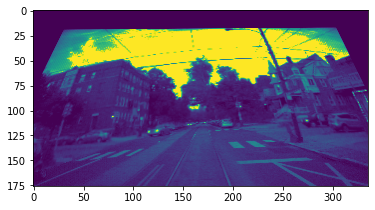

In [16]:
plt.imshow(img1_warp)

In [17]:
imageio.imwrite(os.getcwd() + '\\figure 24.png', img1_warp)